<a id = 'select'></a>
# Model Selection

**Model selection** is the task of selecting a statistical model from a set of candidate models.

**Model selection** may also refer to the problem of selecting a few representative models from a large set of computational models for the purpose of decision making or optimization under uncertainty.

## Table of Content

[A. Individual Account](#indi)

[B. Joint Account](#joint)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Mounting the Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = 'indi'></a>
> ## A. Individual Account

In [ ]:
inv_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Individual_clean_ML.csv')

In [ ]:
inv_df.head()

,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,cibil_score,bal_annual_inc,inst_anmt_ratio,credit_line_ratio
0,1,13.99,6912.03,5,21,10,4,14.943679,0,0,5.91,0,155342.26,29.7,1,0,677,0.065455,0.034175,0.538462
1,1,11.99,46084.68,5,24,10,4,15.110733,0,0,16.06,0,1206220.03,19.2,4,0,717,0.380000,0.033210,0.578947
2,2,14.85,46625.15,5,20,10,4,15.636826,2,1,17.06,0,438329.23,11.6,1,0,787,0.318182,0.023711,0.764706
3,2,22.45,16287.62,2,9,3,4,15.584891,2,0,25.37,0,1232007.40,64.5,6,0,697,0.099585,0.027876,0.342857
4,1,13.44,22763.68,5,22,4,3,14.462706,2,0,10.20,0,495634.52,68.4,0,0,692,0.351471,0.033906,0.833333


In [ ]:
X = inv_df.drop(columns = {'loan_status'})
Y = inv_df['loan_status']

In [ ]:
# Splitting Dataset into Test & Train

target_col = 'loan_status'

#feature space
X_train = inv_df.drop(columns=[target_col])
X_test = inv_df.drop(columns=[target_col])

#target variable
y_train = inv_df[target_col]
y_test = inv_df[target_col]

In [ ]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfpvalue= pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfpvalue,dfscores],axis=1)
featureScores.columns = ['Specs','pvalue','Score']  #naming the dataframe columns
print(featureScores.nlargest(21,'Score'))  #print 10 best features

                   Specs         pvalue         Score
0                   term   0.000000e+00  67633.714338
17       inst_anmt_ratio   0.000000e+00  40388.540133
18     credit_line_ratio   0.000000e+00  33341.310175
1               int_rate   0.000000e+00  19100.099315
13              mort_acc   0.000000e+00  16056.166747
16        bal_annual_inc   0.000000e+00  14750.436095
4              sub_grade   0.000000e+00  10586.229966
3                  grade   0.000000e+00  10070.101464
9                    dti   0.000000e+00   8611.419139
2            installment   0.000000e+00   3429.017140
12            revol_util  1.174681e-285   1304.922835
6         home_ownership  5.944589e-219    997.841181
7             annual_inc   2.577797e-51    227.096296
10               pub_rec   9.618966e-50    219.888737
8    verification_status   2.041796e-49    218.390004
15           cibil_score   4.951594e-28    120.489382
11             revol_bal   5.021931e-25    106.763823
5             emp_length   3

In [ ]:
drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','revol_bal','revol_util']

In [ ]:
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [ ]:
#ROC dict for TPR and FPR values
roc_dict = {}
#precision recall curve
prc_dict = {}

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [ ]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [ ]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,5.562789e-01,5.528525e-01,0.554355,5.545657e-01,5.545485e-01,lr
recall,4.927465e-01,6.147427e-01,0.554355,5.537446e-01,5.543548e-01,lr
f1-score,5.225888e-01,5.821573e-01,0.554355,5.523731e-01,5.526710e-01,lr
support,1.059210e+06,1.080618e+06,0.554355,2.139828e+06,2.139828e+06,lr


In [ ]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [ ]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,6.525293e-01,6.755463e-01,0.663581,6.640378e-01,6.641530e-01,gbtree
recall,6.852664e-01,6.423260e-01,0.663581,6.637962e-01,6.635814e-01,gbtree
f1-score,6.684973e-01,6.585174e-01,0.663581,6.635074e-01,6.634575e-01,gbtree
support,1.059210e+06,1.080618e+06,0.663581,2.139828e+06,2.139828e+06,gbtree


In [ ]:
# metric for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                     subsample=0.9,
                            n_jobs=-1)
xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,7.200851e-01,7.196831e-01,0.719879,7.198841e-01,7.198821e-01,xgb
recall,7.101500e-01,7.294159e-01,0.719879,7.197830e-01,7.198794e-01,xgb
f1-score,7.150830e-01,7.245169e-01,0.719879,7.198000e-01,7.198471e-01,xgb
support,1.059210e+06,1.080618e+06,0.719879,2.139828e+06,2.139828e+06,xgb


In [ ]:
#metrics for xgb
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [ ]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,0,1,accuracy,macro avg,weighted avg,clf
precision,4.951273e-01,8.697368e-01,0.49526,6.824321e-01,6.843060e-01,svc
recall,9.999065e-01,6.116870e-04,0.49526,5.002591e-01,4.952604e-01,svc
f1-score,6.623008e-01,1.222514e-03,0.49526,3.317616e-01,3.284548e-01,svc
support,1.059210e+06,1.080618e+06,0.49526,2.139828e+06,2.139828e+06,svc


In [ ]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

In [ ]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,7.615492e-01,7.559689e-01,0.758675,7.587590e-01,7.587311e-01,KNN
recall,7.460796e-01,7.710208e-01,0.758675,7.585502e-01,7.586750e-01,KNN
f1-score,7.537350e-01,7.634207e-01,0.758675,7.585779e-01,7.586263e-01,KNN
support,1.059210e+06,1.080618e+06,0.758675,2.139828e+06,2.139828e+06,KNN


In [ ]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [ ]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'XGBoost', 'SVC', 'KNN'])

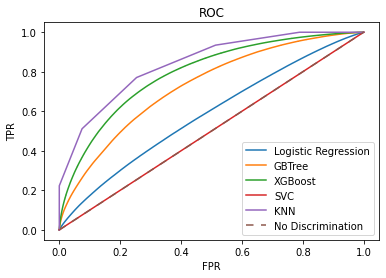

In [ ]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig(os.path.join('roc_curve_all_models.png'))
plt.legend()
plt.show()

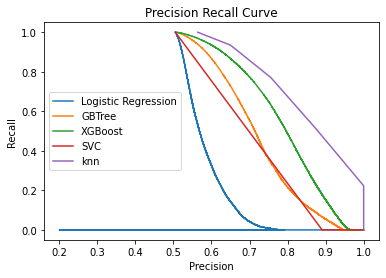

In [ ]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('prc_curve_all_models.png'))

plt.legend()

plt.show()

In [ ]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1,
                           scale_pos_weight=estimate)

xgb_clf.fit(X_train, y_train)

Estimate: 0.980


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9801891140069849,
              seed=None, silent=None, subsample=0.9, verbosity=1)

In [ ]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/model/xgb_individual.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /content/drive/MyDrive/Colab Notebooks/model/xgb_individual.pkl


In [ ]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
knn_clf = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_clf.fit(X_train, y_train)

Estimate: 0.980


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/model/knn_individual.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /content/drive/MyDrive/Colab Notebooks/model/knn_individual.pkl


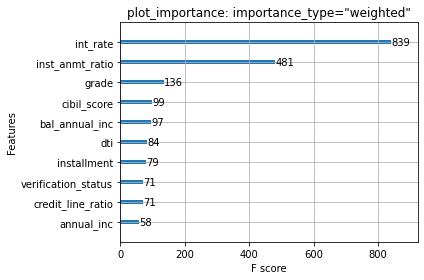

In [ ]:
#”weight” is the number of times a feature appears in a tree
xgb.plot_importance(xgb_clf, 
                    importance_type='weight',
                    max_num_features=10, 
                    title='plot_importance: importance_type="weighted"')
plt.tight_layout()
plt.show()

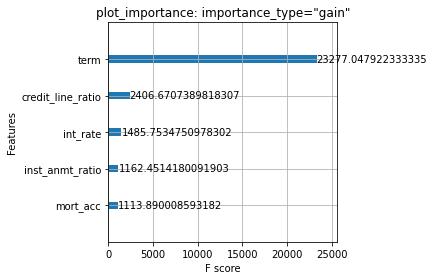

In [ ]:

#”gain” is the average gain of splits which use the feature

xgb.plot_importance(xgb_clf, 
                    importance_type='gain',
                    max_num_features=5, 
                    title='plot_importance: importance_type="gain"')
plt.tight_layout()
plt.show()

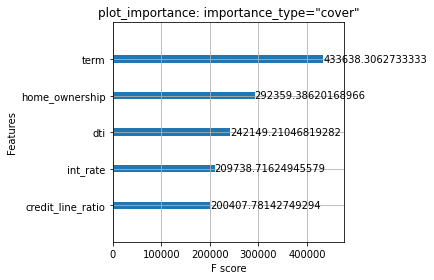

In [ ]:
#is the average coverage of splits which use the feature 
#where coverage is defined as the number of samples affected by the split

xgb.plot_importance(xgb_clf, 
                    importance_type='cover',
                    max_num_features=5, 
                    title='plot_importance: importance_type="cover"')
plt.tight_layout()
plt.show()

In [ ]:
y_pred=xgb_clf.predict(X_test)
y_prob=xgb_clf.predict_proba(X_test)

In [ ]:
y_prob=y_prob[:, 1] #keeping only positive outcomes

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred))

[[754347 304863]
 [294570 786048]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72   1059210
           1       0.72      0.73      0.72   1080618

    accuracy                           0.72   2139828
   macro avg       0.72      0.72      0.72   2139828
weighted avg       0.72      0.72      0.72   2139828



In [ ]:
...
# calculate AUC
auc = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % auc)

AUC: 0.791


<a id = 'joint'></a>
> ## B. Joint Account

In [ ]:
joint_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Joint_clean_ML.csv')

In [ ]:
joint_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,pub_rec_bankruptcies,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,cibil_score,sec_app_cibil_score,balance_annual_inc,sec_balance_annual_inc,inst_amnt_ratio,credit_line_ratio
0,629234.48,2,30.79,20664.73,1,4,1,3,14.720536,0,1,43.97,8,0,11.359007,24.6,14,15.330795,31.94,0,1,4,1,4,8,15.120638,89.00000,1,1,10.947303,84.0,8,1,10,0.0,0,12.896584,3,1,14,80.0,11,8,667,612,42745.352547,41043.826258,0.032841,0.571429
1,1123633.00,1,10.41,36473.69,6,27,6,4,13.880785,1,1,45.17,6,0,13.777995,33.4,9,14.848369,20.86,1,1,1,0,0,59,10.365447,4.00000,1,2,12.849735,24.0,0,0,1,0.0,0,14.059416,0,1,8,44.1,1,6,797,667,80948.805759,75673.834126,0.032461,0.666667
2,1078687.68,2,17.47,27081.80,4,19,5,3,14.533658,1,1,19.76,14,0,13.523735,62.1,18,14.906638,19.15,2,0,0,0,0,0,0.000000,68.54683,0,1,11.855838,62.0,0,0,0,0.0,0,13.739404,0,0,14,59.0,0,16,677,672,74219.970222,72362.909752,0.025106,0.777778
3,1404541.25,2,12.61,31678.02,5,24,6,4,14.625225,0,1,27.78,8,0,15.612915,60.6,16,15.636826,12.15,0,0,0,0,0,57,0.000000,68.54683,0,2,12.947377,61.0,0,2,1,2.0,0,14.509646,0,2,10,56.0,0,11,727,692,96035.528653,89822.656478,0.022554,0.500000
4,168544.95,1,10.41,5471.53,6,27,10,4,15.030690,0,1,27.94,20,0,13.799861,24.1,36,15.390693,20.64,0,3,4,3,4,1,14.593270,81.00000,3,8,12.397519,47.0,2,0,7,5.0,0,14.737214,2,0,6,32.1,1,5,772,642,11213.387164,10951.095593,0.032463,0.555556


In [ ]:
X = joint_df.drop(columns = {'loan_status'})
Y = joint_df['loan_status']

In [ ]:
# Splitting Dataset into Test & Train

target_col = 'loan_status'

#feature space
X_train = joint_df.drop(columns=[target_col])
X_test = joint_df.drop(columns=[target_col])

#target variable
y_train = joint_df[target_col]
y_test = joint_df[target_col]

In [ ]:
#ROC dict for TPR and FPR values
roc_dict = {}
#precision recall curve
prc_dict = {}

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [ ]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [ ]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.0,0.870280,0.87028,0.435140,0.757387,lr
recall,0.0,1.000000,0.87028,0.500000,0.870280,lr
f1-score,0.0,0.930641,0.87028,0.465321,0.809918,lr
support,13899.0,93247.000000,0.87028,107146.000000,107146.000000,lr


In [ ]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [ ]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.888889,0.870344,0.870345,0.879616,0.872749,gbtree
recall,0.000576,0.999989,0.870345,0.500282,0.870345,gbtree
f1-score,0.001150,0.930673,0.870345,0.465912,0.810095,gbtree
support,13899.000000,93247.000000,0.870345,107146.000000,107146.000000,gbtree


In [ ]:
# metric for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                     subsample=0.9,
                            n_jobs=-1)
xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.860000,0.870621,0.870616,0.865310,0.869243,xgb
recall,0.003094,0.999925,0.870616,0.501509,0.870616,xgb
f1-score,0.006165,0.930804,0.870616,0.468484,0.810859,xgb
support,13899.000000,93247.000000,0.870616,107146.000000,107146.000000,xgb


In [ ]:
#metrics for xgb
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [ ]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.638177,0.873633,0.87209,0.755905,0.843090,svc
recall,0.032233,0.997276,0.87209,0.514754,0.872090,svc
f1-score,0.061366,0.931369,0.87209,0.496367,0.818512,svc
support,13899.000000,93247.000000,0.87209,107146.000000,107146.000000,svc


In [ ]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

In [ ]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.629695,0.881067,0.875758,0.755381,0.848459,KNN
recall,0.102525,0.991013,0.875758,0.546769,0.875758,KNN
f1-score,0.176340,0.932812,0.875758,0.554576,0.834682,KNN
support,13899.000000,93247.000000,0.875758,107146.000000,107146.000000,KNN


In [ ]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [ ]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'XGBoost', 'SVC', 'KNN'])

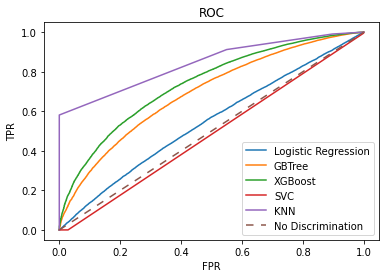

In [ ]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig(os.path.join('roc_curve_all_models_joint.png'))
plt.legend()
plt.show()

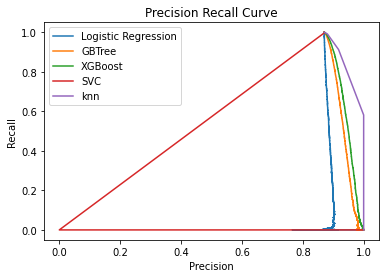

In [ ]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('prc_curve_all_models_joint.png'))

plt.legend()

plt.show()

In [ ]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1,
                           scale_pos_weight=estimate)

xgb_clf.fit(X_train, y_train)

Estimate: 0.149


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.14905573369652644,
              seed=None, silent=None, subsample=0.9, verbosity=1)

In [ ]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/model/xgb_joint.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /content/drive/MyDrive/Colab Notebooks/model/xgb_joint.pkl


In [ ]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
knn_clf = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_clf.fit(X_train, y_train)

Estimate: 0.149


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/model/knn_joint.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /content/drive/MyDrive/Colab Notebooks/model/knn_joint.pkl


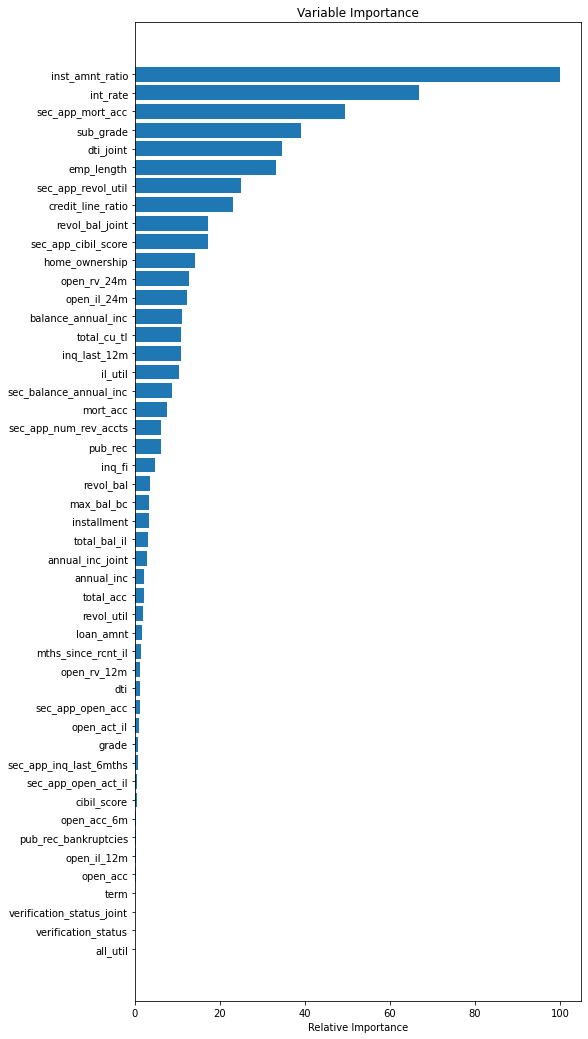

In [ ]:
feature_importance = gbtree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

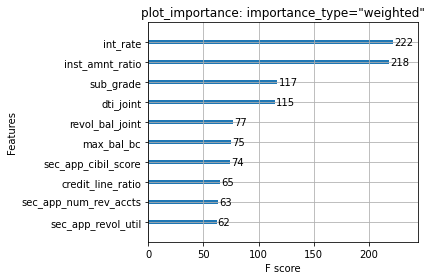

In [ ]:
#”weight” is the number of times a feature appears in a tree
xgb.plot_importance(xgb_clf, 
                    importance_type='weight',
                    max_num_features=10, 
                    title='plot_importance: importance_type="weighted"')
plt.tight_layout()
plt.show()

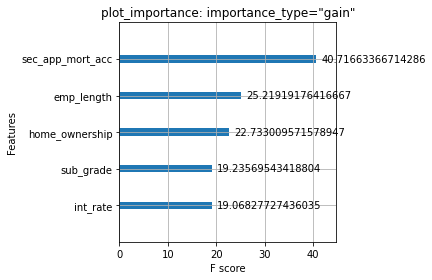

In [ ]:

#”gain” is the average gain of splits which use the feature

xgb.plot_importance(xgb_clf, 
                    importance_type='gain',
                    max_num_features=5, 
                    title='plot_importance: importance_type="gain"')
plt.tight_layout()
plt.show()

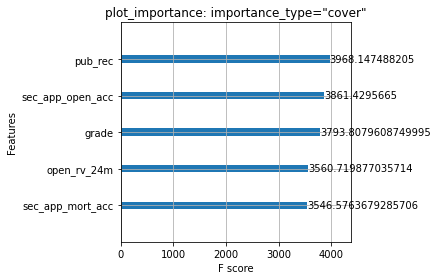

In [ ]:
#is the average coverage of splits which use the feature 
#where coverage is defined as the number of samples affected by the split

xgb.plot_importance(xgb_clf, 
                    importance_type='cover',
                    max_num_features=5, 
                    title='plot_importance: importance_type="cover"')
plt.tight_layout()
plt.show()

In [ ]:
y_pred=xgb_clf.predict(X_test)
y_prob=xgb_clf.predict_proba(X_test)

In [ ]:
y_prob=y_prob[:, 1] #keeping only positive outcomes

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred))

[[ 9721  4178]
 [32303 60944]]
              precision    recall  f1-score   support

           0       0.23      0.70      0.35     13899
           1       0.94      0.65      0.77     93247

    accuracy                           0.66    107146
   macro avg       0.58      0.68      0.56    107146
weighted avg       0.84      0.66      0.71    107146



In [ ]:
...
# calculate AUC
auc = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % auc)

AUC: 0.741
